In [71]:
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder

## 0. Findings

- Nov, Dec, Jan have the highest amount of deenergizations, ~90% of events
- Very few outliers, compact wind and FPI values
- A combination of High Wind and FPI values drive deenergizations
- 193 different circuits deenergized

### Sections
- [Section 1](#1.--Input,-Prep-and-Visualize-Data):  Input
- [Section 2](#2.-Remove-Outliers):  Outliers
- [Section 3](#3.-Inspect-Categorical-Values):  Categoricals
- [Section 4](#4.-Curve-Fitting):  Curve Fitting
- [Section 5](#5.-Simulation):  Simulation

## 1.  Input, Prep and Visualize Data

In [72]:
decision_columns = ["Circuit", "Weather Station", "Wind Sustained", "Gust Sustained", "Thresholds (Sustained/ Gust)", "FPI Value", "Reasons for De‐Energization", "month", "days", "year"]
nulls = ['‐', 'circuit imminent re‐en)', 'ircuit imminent re‐en)', '99th Percentile Exceeded', '99th Percentile Exceede', '99th Percentile Exceed', '14+', "N", "A", 'N/']
decision_2020 = pd.read_csv("../data/2020/decision_2020.csv", na_values=nulls)
decision_2021 = pd.read_csv("../data/2021/decision_2021.csv", na_values=nulls)

In [73]:
decision_2020.columns = decision_columns
decision_2021 = decision_2021[decision_columns]

In [74]:
decision = pd.concat([decision_2020, decision_2021])
decision.head()

,Circuit,Weather Station,Wind Sustained,Gust Sustained,Thresholds (Sustained/ Gust),FPI Value,Reasons for De‐Energization,month,days,year
0,ANTON,SCE Magic Mountain Truck Trail,35.0,53.0,31/46,13.88,Exceeded Threshold 99th Percentile Exceeded ...,Sept,5-11,2020
1,BOOTLEGGER,SCE Antelope Valley Fwy,16.0,41.0,31/46,13.98,Exceeded Threshold FPI Value,Sept,5-11,2020
2,LOUCKS,SCE Antelope Valley Fwy,16.0,37.0,31/46,14.77,Exceeded Threshold FPI Value,Sept,5-11,2020
3,RED BOX,Chilao (CHOC1),16.0,46.0,31/46,14.01,Exceeded Threshold FPI Value,Sept,5-11,2020
4,SHOVEL,SCE Antelope Valley Fwy,16.0,37.0,31/46,14.84,Exceeded Threshold FPI Value,Sept,5-11,2020


### 1a. Split Thresholds column and create numeric columns

In [75]:
#numeric_columns = ["Customers De‐Energized", "FPI Value", "Wind Sustained", "Gust Sustained", "Wind Threshold", "Gust Threshold", "Adjusted Wind Trigger", "Adjusted Gust Trigger"]
numeric_columns = ["FPI Value", "Wind Sustained", "Gust Sustained", "Wind Threshold", "Gust Threshold"]
categorical_columns = ["Circuit", "Reasons for De‐Energization", "month", "year", "days"]

In [76]:
# Create/Format numeric columns
decision[["Wind Threshold", "Gust Threshold"]] = decision["Thresholds (Sustained/ Gust)"].str.split("/", expand=True)
#decision[["Adjusted Wind Trigger", "Adjusted Gust Trigger"]] = decision["Adjusted Triggers (Sustained/ Gust)"].str.split("/", expand=True)

for c in numeric_columns:
    decision[c] = pd.to_numeric(decision[c])

decision["Wind Trigger Percentage"] = decision["Wind Sustained"]/decision["Wind Threshold"] * 100
decision["Gust Trigger Percentage"] = decision["Gust Sustained"]/decision["Gust Threshold"] * 100
decision["Combined Trigger Percentage"] = decision[["Wind Trigger Percentage", "Gust Trigger Percentage"]].max(axis=1)
numeric_columns+= ["Wind Trigger Percentage", "Gust Trigger Percentage", "Combined Trigger Percentage"]

In [77]:
raw_stats = decision[numeric_columns].describe(percentiles=np.arange(0,1,.1))
raw_stats

,FPI Value,Wind Sustained,Gust Sustained,Wind Threshold,Gust Threshold,Wind Trigger Percentage,Gust Trigger Percentage,Combined Trigger Percentage
count,564.000000,566.000000,566.000000,568.000000,567.000000,566.000000,565.000000,566.000000
mean,12.823333,27.240883,46.061449,30.440229,44.968448,89.441953,102.467653,104.973130
std,0.719145,9.312205,7.520016,1.763409,2.365339,29.665988,15.818807,24.699502
min,8.970000,7.900000,15.000000,18.000000,29.000000,25.483871,32.608696,32.608696
0%,8.970000,7.900000,15.000000,18.000000,29.000000,25.483871,32.608696,32.608696
10%,12.000000,17.850000,38.450000,28.040000,42.000000,60.000000,86.956522,89.120773
20%,12.110000,21.300000,40.900000,31.000000,45.000000,70.322581,91.086957,92.826087
30%,12.449000,23.600000,42.250000,31.000000,46.000000,78.387097,94.756522,96.129032
40%,12.530000,25.630000,43.700000,31.000000,46.000000,83.870968,97.826087,99.032258
50%,12.700000,27.000000,45.265000,31.000000,46.000000,89.654762,100.238095,101.054348


### 1b. Create data columns

In [157]:
date_cols = ["month", "days", "year"]
source[["event start", "event end"]] = source["days"].str.split("-", expand=True)
date_cols += ["event start", "event end"]

In [158]:
single_day_events = source["event end"].isna()
source.loc[source["event end"].isna(), "event end"] = source[single_day_events]["event start"]

In [159]:
source.loc[source.year == "PSPS", "year"] = 2020

In [160]:
str_combine = lambda s1, s2: str(s1) + "-" + str(s2)
source["start"] = source.year.combine(source.month, str_combine).combine(source["event start"], str_combine)
source["end"] = source.year.combine(source.month, str_combine).combine(source["event end"], str_combine)
date_cols += ["start", "end"]

In [161]:
for s in ["start", "end"]:
    source[s] = pd.to_datetime(source[s])

In [162]:
source.dtypes

Circuit                                 object
Weather Station                         object
Wind Sustained                         float64
Gust Sustained                         float64
Thresholds (Sustained/ Gust)            object
FPI Value                              float64
Reasons for De‐Energization             object
month                                   object
days                                    object
year                                    object
Wind Threshold                         float64
Gust Threshold                         float64
Wind Trigger Percentage                float64
Gust Trigger Percentage                float64
Combined Trigger Percentage            float64
event start                             object
event end                               object
start                           datetime64[ns]
end                             datetime64[ns]
dtype: object

### 1b. Histograms of numeric values

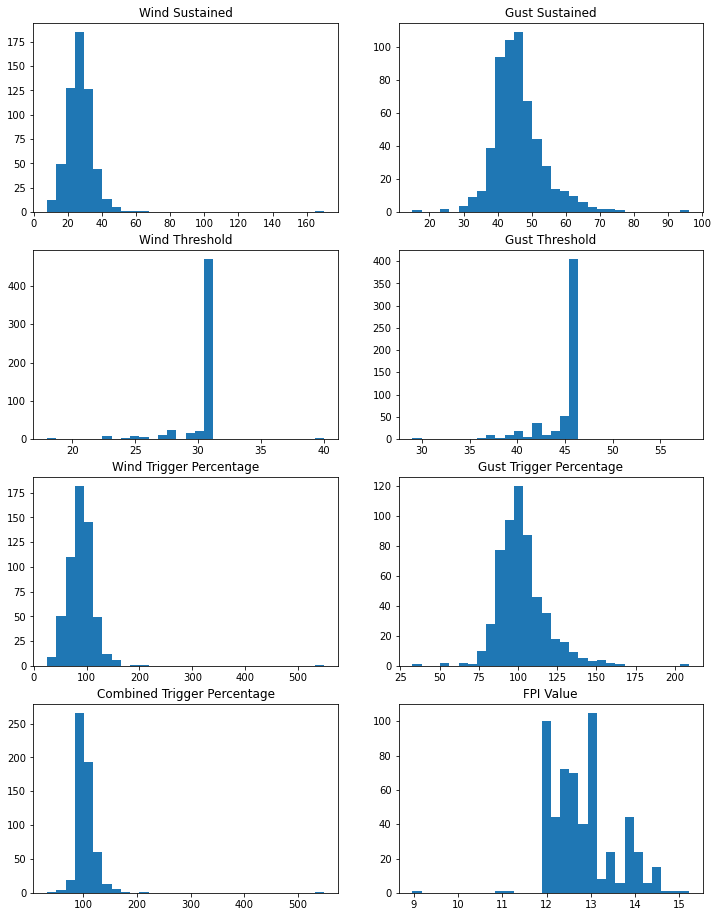

In [83]:
fig, ax = plt.subplots(4,2, figsize = (12,16))
for (x, c) in zip(ax.flatten(), numeric_columns[1:] + ["FPI Value"]):
    x.hist(decision[c].values, bins=30)
    x.set_title(c)

### 1c. Plots of FPI and Wind values

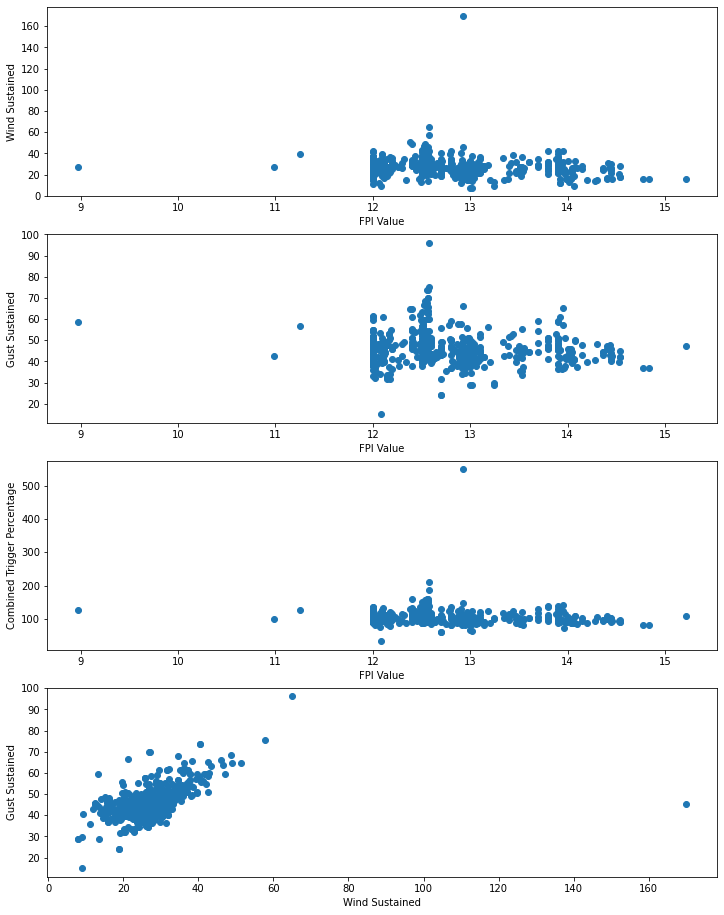

In [84]:
fig, ax = plt.subplots(4,1, figsize = (12,16))
for (p,q),x in zip(itertools.combinations(numeric_columns[:3]+[numeric_columns[-1]],2),ax):
    data = decision[[p,q]].values
    x.scatter(data[:,0], data[:,1])
    x.set_xlabel(p)
    x.set_ylabel(q)

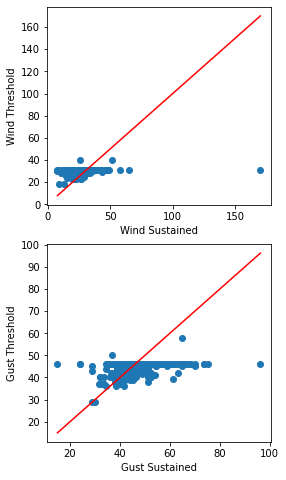

In [85]:
air = ["Wind Sustained", "Gust Sustained"]
triggers = ["Wind Threshold", "Gust Threshold"]
fig, axes = plt.subplots(2,1, figsize = (4,8))
for (p,q),ax in zip(zip(air,triggers),axes):
    data = decision[[p,q]].dropna().values
    ax.scatter(data[:,0], data[:,1])

    g = np.min(data[:,0])
    G = np.max(data[:,0])
    ax.plot([g,G],[g,G], linestyle='-' ,color='red')

    ax.set_xlabel(p)
    ax.set_ylabel(q)

## 2. Remove Outliers
[(back to top)](#0.-Findings)

In [86]:
# Remove outliers
# FPI Value < 11
fpi_inliers = (decision["FPI Value"] > 11) & (decision["FPI Value"] < 14.6) # from pdf
wind_inliers = decision["Wind Sustained"] < 50 # from inspection
reason_inliers = decision["Reasons for De‐Energization"].isin(decision["Reasons for De‐Energization"].value_counts()[:8].index)
threshold_inliers = decision["Combined Trigger Percentage"] > 80

source = decision[(fpi_inliers) & (wind_inliers) & (reason_inliers) & threshold_inliers].dropna().reset_index(drop=True)

In [87]:
source.head()

,Circuit,Weather Station,Wind Sustained,Gust Sustained,Thresholds (Sustained/ Gust),FPI Value,Reasons for De‐Energization,month,days,year,Wind Threshold,Gust Threshold,Wind Trigger Percentage,Gust Trigger Percentage,Combined Trigger Percentage
0,BOOTLEGGER,SCE Antelope Valley Fwy,16.0,41.0,31/46,13.98,Exceeded Threshold FPI Value,Sept,5-11,2020,31.0,46.0,51.612903,89.130435,89.130435
1,RED BOX,Chilao (CHOC1),16.0,46.0,31/46,14.01,Exceeded Threshold FPI Value,Sept,5-11,2020,31.0,46.0,51.612903,100.000000,100.000000
2,ENERGY,SCE Santa Susana Pass Rd,16.9,43.8,31/46,13.04,High Wind Trend Exceeded FPI,Nov,29,2020,31.0,46.0,54.516129,95.217391,95.217391
3,SAND CANYON,SCE Magic Mtn Truck Trail,30.6,40.3,31/46,12.11,High Wind Trend Exceeded FPI,Nov,29,2020,31.0,46.0,98.709677,87.608696,98.709677
4,DUKE,SCE Mount Davis,26.9,40.6,30/46,13.04,High Wind Trend Exceeded FPI,Nov,29,2020,30.0,46.0,89.666667,88.260870,89.666667


In [88]:
source_stats = source[numeric_columns].describe(percentiles=np.arange(0,1,.1))
raw_stats-source_stats

,FPI Value,Wind Sustained,Gust Sustained,Wind Threshold,Gust Threshold,Wind Trigger Percentage,Gust Trigger Percentage,Combined Trigger Percentage
count,40.000000,42.000000,4.200000e+01,44.000000,43.000000,42.000000,4.100000e+01,42.000000
mean,-0.004720,0.329185,7.786098e-02,0.056603,0.070337,0.897637,4.418895e-02,0.849090
std,0.036339,2.666966,8.373169e-01,0.047209,0.016039,8.551453,1.972942e+00,10.555059
min,-3.030000,-1.040000,-1.400000e+01,0.000000,0.000000,-4.193548,-4.282609e+01,-47.608696
0%,-3.030000,-1.040000,-1.400000e+01,0.000000,0.000000,-4.193548,-4.282609e+01,-47.608696
10%,0.000000,-0.180000,-5.800000e-01,0.040000,0.000000,-0.193548,-5.000000e-01,-0.474879
20%,0.000000,-0.200000,-6.800000e-02,0.000000,0.000000,-1.322581,-2.173913e-01,-0.046283
30%,0.000000,0.000000,-1.950000e-01,0.000000,0.000000,-0.303465,-2.217391e-01,0.000000
40%,0.000000,-0.014000,-2.000000e-02,0.000000,0.000000,-0.322581,1.421085e-14,-0.015771
50%,0.000000,0.010000,8.500000e-02,0.000000,0.000000,0.292981,1.334776e-02,0.000000


In [89]:
def stats_summary(s): return source_stats.loc["mean", s], source_stats.loc["std", s]
stats_summary("Wind Sustained")

(26.911698473282467, 6.645238607728819)

### 2a. Check plots again

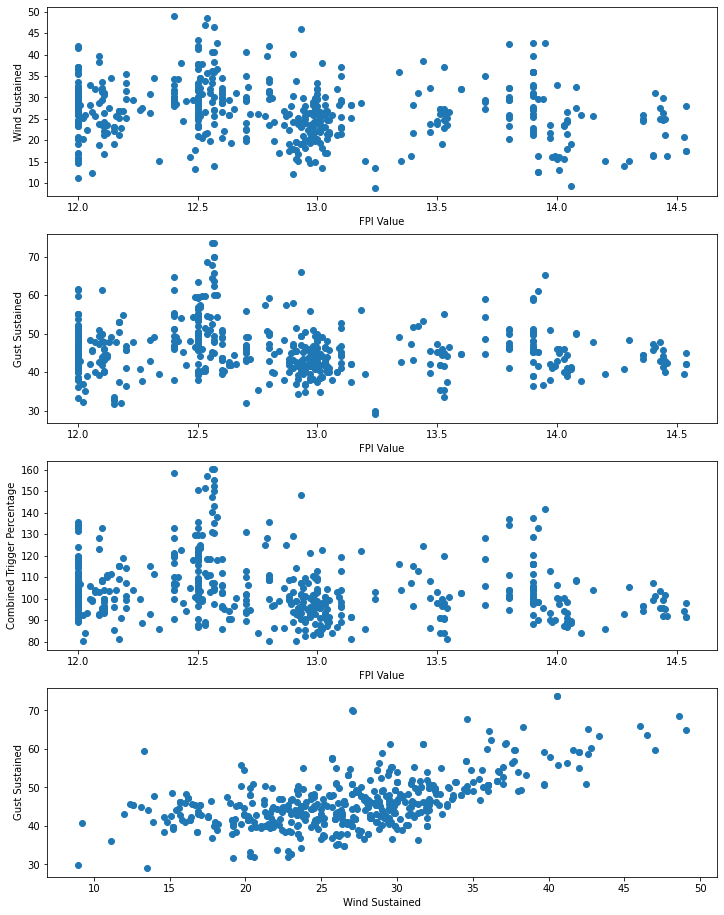

In [90]:
fig, ax = plt.subplots(4,1, figsize = (12,16))
for (p,q),x in zip(itertools.combinations(numeric_columns[:3]+[numeric_columns[-1]],2),ax):
    data = source[[p,q]].values
    x.scatter(data[:,0], data[:,1])
    x.set_xlabel(p)
    x.set_ylabel(q)

### 2b. Clustering

In [91]:
features = [numeric_columns[0], numeric_columns[-1]]
kmeans = KMeans(n_clusters=3, n_init=100, random_state=123).fit(source[features])

In [92]:
pd.Series(kmeans.labels_).value_counts()

1    281
0    192
2     51
dtype: int64

Text(0, 0.5, 'Combined Trigger Percentage')

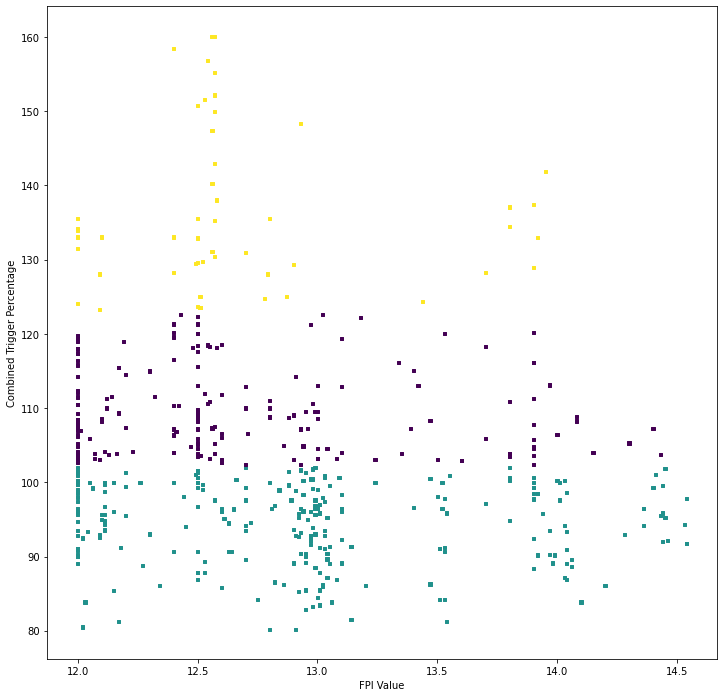

In [93]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
# for (p,q),x in zip(itertools.combinations(features,2),ax):
data = source[features].values
ax.scatter(data[:,0], data[:,1], c=kmeans.labels_, marker=',', s=10)
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])

In [94]:
# data = source.values
# fig = plt.figure(1, figsize=(6, 6))
# ax = Axes3D(fig,  elev=25, azim=-35)
# ax.scatter(data[:,0], data[:,1], data[:,2], c=kmeans.labels_, edgecolor='k')
# ax.set_xlabel(features[0])
# ax.set_ylabel(features[1])
# ax.set_zlabel(features[2])

## 3. Inspect Categorical Values

[(back to top)](#0.-Findings)

### 3a. Months

In [95]:
# Look at breakdown by Month
months = source.groupby("month").describe()
months[("FPI Value", "meanTomax")] = months[("FPI Value", "max")]/months[("FPI Value", "mean")]
months["FPI Value"].sort_values("count", ascending=False)

,count,mean,std,min,25%,50%,75%,max,meanTomax
month,,,,,,,,,
Dec,175.0,13.135600,0.776223,12.00,12.7950,12.980,13.9000,14.54,1.106916
Nov,161.0,12.780994,0.687213,12.00,12.1000,12.950,13.0500,14.53,1.136844
Jan,148.0,12.536149,0.388013,12.00,12.4000,12.500,12.7000,13.80,1.100817
Oct,38.0,12.686579,0.473602,12.20,12.5250,12.560,12.5700,14.30,1.127175
Sept,2.0,13.995000,0.021213,13.98,13.9875,13.995,14.0025,14.01,1.001072


In [96]:
source.month.value_counts()/source.month.value_counts().sum()

Dec     0.333969
Nov     0.307252
Jan     0.282443
Oct     0.072519
Sept    0.003817
Name: month, dtype: float64

In [97]:
months[("Combined Trigger Percentage", "meanTomax")] = months[("Combined Trigger Percentage", "max")]/months[("Combined Trigger Percentage", "mean")]
months["Combined Trigger Percentage"].sort_values("count", ascending=False)
# Filter when "High Wind" is present as a reason

,count,mean,std,min,25%,50%,75%,max,meanTomax
month,,,,,,,,,
Dec,175.0,101.588272,10.792932,80.217391,95.119048,100.000000,107.173913,137.419355,1.352709
Nov,161.0,99.539647,12.026421,80.500000,90.652174,96.956522,104.782609,141.847826,1.425038
Jan,148.0,107.528065,13.652760,80.217391,99.021739,104.282609,115.027778,158.387097,1.472984
Oct,38.0,122.470570,19.841916,99.434783,104.402174,118.259818,137.355715,160.108696,1.307324
Sept,2.0,94.565217,7.685943,89.130435,91.847826,94.565217,97.282609,100.000000,1.057471


In [98]:
#months_names = ["Dec", "Jan"]
months_names = months.index.values
months_c_map = {months_names[i]:i for i in range(len(months_names
                                                    ))}
months_colors = source[source.month.isin(months_names)]["month"].apply(lambda r: months_c_map[r])

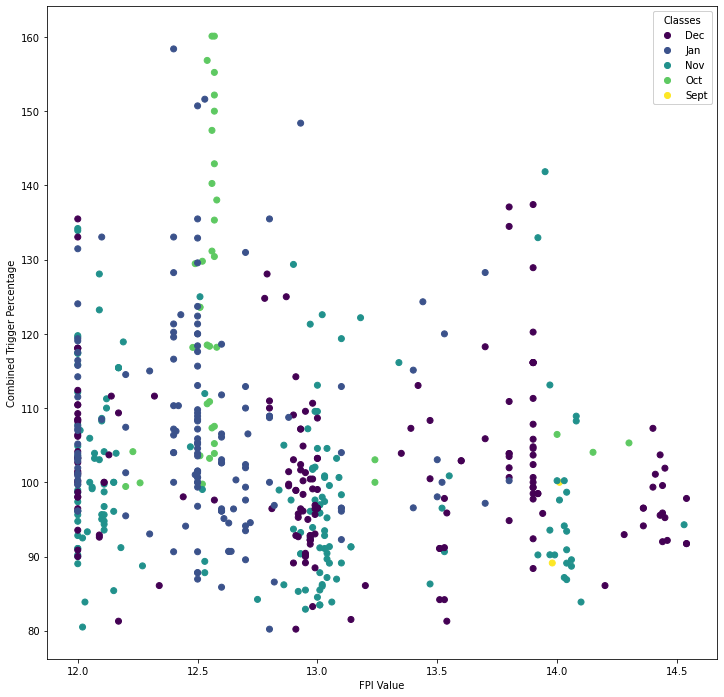

In [99]:
fig, ax = plt.subplots(1,1, figsize = (12,12))

data = source[source.month.isin(months_names)][features].values
scatter = ax.scatter(data[:,0], data[:,1], c=months_colors.values)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])

handles, _ = scatter.legend_elements()
legend1 = ax.legend(handles, months_names, loc="upper right", title="Classes")
ax.add_artist(legend1)

plt.show()

### 3b. Circuits

In [100]:
# Look at breakdown of most common circuits
circuits = source.groupby("Circuit").describe().dropna()
circuits[("FPI Value", "meanTomax")] = circuits[("FPI Value", "max")]/circuits[("FPI Value", "mean")]
circuits["FPI Value"].sort_values("count", ascending=False).iloc[:10]

,count,mean,std,min,25%,50%,75%,max,meanTomax
Circuit,,,,,,,,,
ENERGY,18.0,12.763333,0.523473,12.10,12.5000,12.540,13.0000,13.90,1.089057
ANTON,14.0,12.897857,0.636712,12.05,12.5000,12.605,12.9700,14.03,1.087778
SAND CANYON,14.0,12.939286,0.539223,12.11,12.7000,12.980,13.1000,13.90,1.074248
DAVENPORT,11.0,12.997273,1.030477,12.11,12.1100,12.720,13.6800,14.54,1.118696
SHOVEL,10.0,12.627000,0.621808,12.11,12.1325,12.370,12.8600,13.80,1.092896
BIG ROCK,10.0,12.696000,0.564392,12.00,12.2625,12.685,12.9850,13.90,1.094833
CONDOR,10.0,13.153000,0.678741,12.00,13.1000,13.305,13.5100,14.10,1.071999
NORTHPARK,8.0,13.352500,0.632066,12.50,12.8525,13.450,13.9050,13.99,1.047744
CALSTATE,8.0,12.892500,0.775514,12.00,12.3750,12.680,13.5975,13.95,1.082024


In [101]:
circuits[("Combined Trigger Percentage", "meanTomax")] = circuits[("Combined Trigger Percentage", "max")]/circuits[("Combined Trigger Percentage", "mean")]
circuits["Combined Trigger Percentage"].sort_values("count", ascending=False).iloc[:10]

,count,mean,std,min,25%,50%,75%,max,meanTomax
Circuit,,,,,,,,,
ENERGY,18.0,108.921576,18.971523,88.478261,100.000000,103.895512,108.152174,158.387097,1.454139
ANTON,14.0,102.929423,14.444622,87.173913,92.500000,101.630435,108.168654,130.967742,1.272403
SAND CANYON,14.0,107.046233,15.910938,83.260870,97.887973,103.478261,112.340463,151.612903,1.416331
DAVENPORT,11.0,96.960474,7.038947,86.565217,92.652174,94.565217,100.978261,108.913043,1.123273
SHOVEL,10.0,100.545989,15.517868,80.217391,91.200000,100.201087,109.687500,131.150000,1.304378
BIG ROCK,10.0,110.191024,21.550643,84.516129,96.129032,102.927770,123.838008,152.173913,1.381001
CONDOR,10.0,94.126227,8.704185,83.870968,91.086957,91.086957,96.521739,112.903226,1.199487
NORTHPARK,8.0,99.688815,8.166519,90.217391,92.826087,99.516129,105.217391,113.043478,1.133964
CALSTATE,8.0,132.552507,8.450661,120.000000,126.646213,134.053296,138.284537,142.913043,1.078162


In [102]:
source.Circuit.value_counts().describe()

count    192.000000
mean       2.729167
std        2.592697
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       18.000000
Name: Circuit, dtype: float64

### 3c. Reasons for Deenergization

In [103]:
source["Reasons for De‐Energization"].value_counts()

Exceeded Threshold Exceeded FPI                                            250
High Wind Trend Exceeded FPI                                               211
High Wind Trend Exceeded FPI Value                                          23
 Exceeded Threshold  1% Historical  High Wind Trend  Exceeded FPI Value     19
 Exceeded Threshold  High Wind Trend  Exceeded FPI Value                    15
 Met Threshold  High Wind Trend  Exceeded FPI Value                          4
 Exceeded Threshold  FPI Value                                               2
Name: Reasons for De‐Energization, dtype: int64

In [104]:
wind_reasons = ["Exceeded Threshold", "High Wind Trend", "1% Historical"]
fpi_reasons = ["Exceeded FPI"]
reasons = wind_reasons + fpi_reasons; reasons

['Exceeded Threshold', 'High Wind Trend', '1% Historical', 'Exceeded FPI']

In [105]:
# Clean up
source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.replace("Exceeded FPI Value", "Exceeded FPI")
source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.replace("99th Percentile", "1% Historical")
source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.replace("Met Threshold ", "")
source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.replace("FPI Value", "Exceeded FPI")

for r in reasons:
    source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.replace(r, r + ",")
source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.replace("  ", " ")
source["Reasons for De‐Energization"] = source["Reasons for De‐Energization"].str.strip()

In [106]:
source["Reasons for De‐Energization"].value_counts()

Exceeded Threshold, Exceeded FPI,                                    252
High Wind Trend, Exceeded FPI,                                       238
Exceeded Threshold, 1% Historical, High Wind Trend, Exceeded FPI,     19
Exceeded Threshold, High Wind Trend, Exceeded FPI,                    15
Name: Reasons for De‐Energization, dtype: int64

In [107]:
c_map = {
    "Exceeded Threshold, Exceeded FPI,": 0,
    "High Wind Trend, Exceeded FPI,": 1,
    "Exceeded Threshold, 1% Historical, High Wind Trend, Exceeded FPI,": 2,
    "Exceeded Threshold, High Wind Trend, Exceeded FPI,":2
}

colors = source["Reasons for De‐Energization"].apply(lambda r: c_map[r])

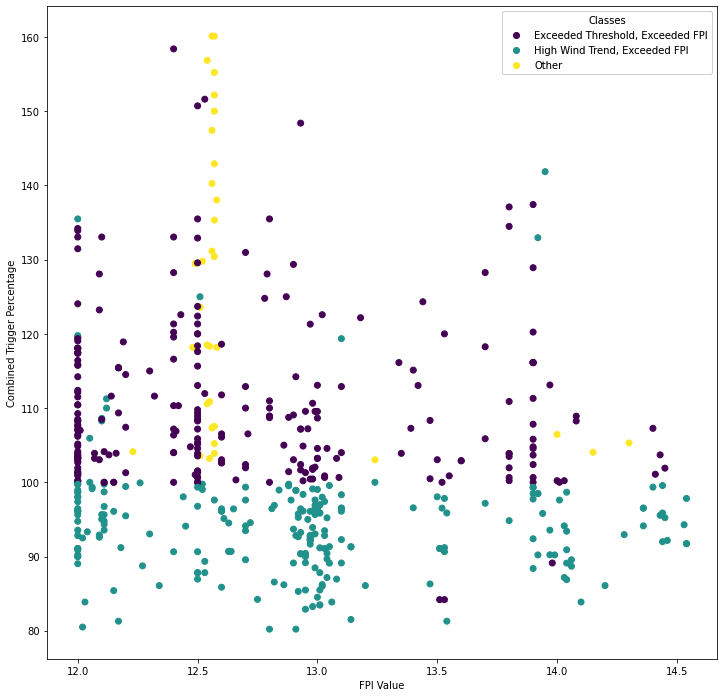

In [108]:
fig, ax = plt.subplots(1,1, figsize = (12,12))

data = source[features].values
scatter = ax.scatter(data[:,0], data[:,1], c=colors.values)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])

handles, _ = scatter.legend_elements()
legend1 = ax.legend(handles, ["Exceeded Threshold, Exceeded FPI", "High Wind Trend, Exceeded FPI", "Other"], loc="upper right", title="Classes")
ax.add_artist(legend1)

plt.show()

In [109]:
source.to_csv("../data/source.csv", index=False)

## 4. Curve Fitting

* If a component was deenergized for given FPI, Wind values, assume deenergization would happen if either value was greater
* High-pass filter:  Only need a reasonable lower bound to the data

[(back to top)](#0.-Findings)

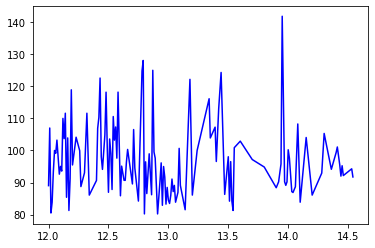

In [110]:
mins = source[features].groupby("FPI Value", as_index=False).min().values
plt.plot(mins[:,0], mins[:,1], color='blue')

In [111]:
# Given point, find next point up and to the left
# Draw horizontal line extending left, raise until it meets next point
# Produces piecewise linear curve
# Apply curve fitting

In [112]:
data = source[features].reset_index(drop=True)

In [113]:
def generate_floor(start, data=data):
    points = pd.DataFrame([start])
    
    #backwards pass
    current = start
    while True:
        elbow = data[(data["FPI Value"] < current["FPI Value"]) & (data["Combined Trigger Percentage"] > current["Combined Trigger Percentage"])]
        next_wind = elbow["Combined Trigger Percentage"].min()
        next_point = elbow[elbow["Combined Trigger Percentage"] == next_wind].max()
        #print(next_point)
        if next_point.isna().any():
            break
        else:
            elbow_point = pd.DataFrame([(current["FPI Value"], next_point["Combined Trigger Percentage"])], columns=["FPI Value", "Combined Trigger Percentage"])
            points = points.append(elbow_point, ignore_index=True)
            
            points = points.append(next_point, ignore_index=True)
            
            current = next_point
    
    #forwards pass
    current = start
    while True:
        elbow = data[(data["FPI Value"] > current["FPI Value"]) & (data["Combined Trigger Percentage"] < current["Combined Trigger Percentage"])]
        next_wind = elbow["Combined Trigger Percentage"].max()
        next_point = elbow[elbow["Combined Trigger Percentage"] == next_wind].min()
        #print(next_point)
        if next_point.isna().any():
            break
        else:
            elbow_point = pd.DataFrame([(next_point["FPI Value"], current["Combined Trigger Percentage"])], columns=["FPI Value", "Combined Trigger Percentage"])
            points = points.append(elbow_point, ignore_index=True)
            
            points = points.append(next_point, ignore_index=True)
            
            current = next_point
    return points.sort_values(by=["FPI Value", "Combined Trigger Percentage"], ascending=[True,False])

In [114]:
def visualize_floor(start, fig=None, ax=None, data=data, iterate=False):
    floor = generate_floor(start, data=data)
    elbow_data = floor.values
    
    if not fig and not ax:
        fig, ax = plt.subplots(1,1, figsize = (12,12))

    ax.scatter(data.values[:,0], data.values[:,1])
    
    ax.plot(elbow_data[:,0], elbow_data[:,1], color='red')
    ax.plot(start["FPI Value"], start["Combined Trigger Percentage"], color='green', marker='o')
    
    if iterate:
        last = floor.iloc[-1]
        final_floor = generate_floor(last, data=data)
        final_elbow_data = final_floor.values
        ax.plot(final_elbow_data[:,0], final_elbow_data[:,1], color='red')
        ax.plot(last["FPI Value"], last["Combined Trigger Percentage"], color='green', marker='o')
        
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    
    return floor, ax

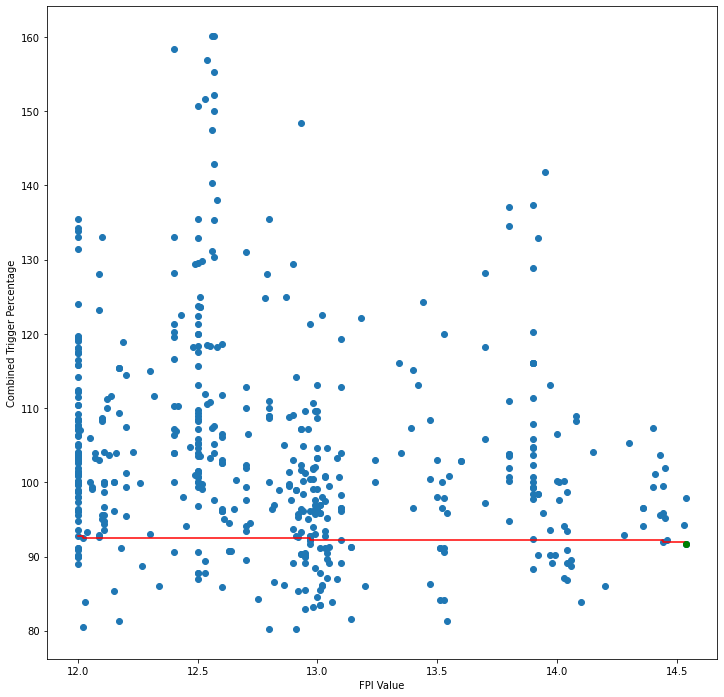

In [115]:
max_FPI = data["FPI Value"].max()
start = data[data["FPI Value"] == max_FPI].min()

_, ax = visualize_floor(start)

<AxesSubplot:xlabel='FPI Value', ylabel='Combined Trigger Percentage'>

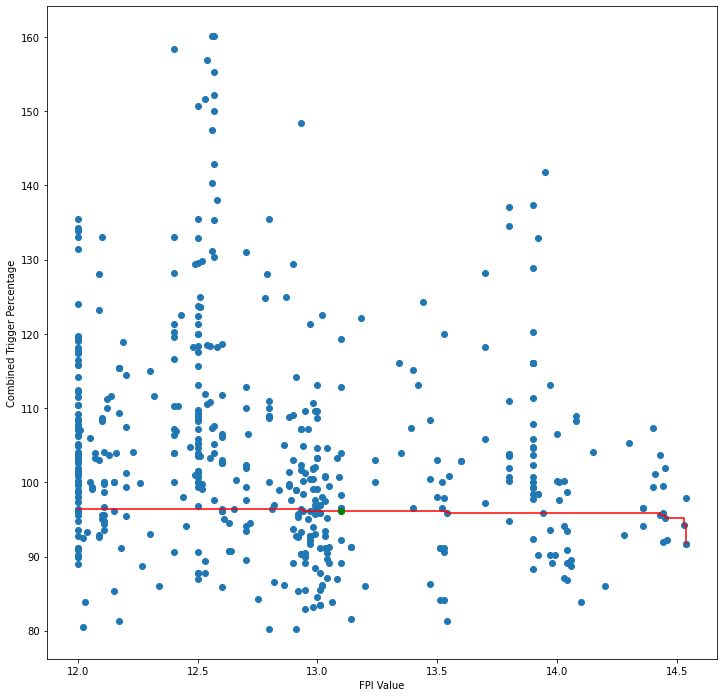

In [116]:
rand_start = data.iloc[np.random.choice(data[(data["Combined Trigger Percentage"] < 100) & (data["FPI Value"] > 12.75) & (data["FPI Value"] < 13.25)].index)]
points, ax = visualize_floor(rand_start)
ax

In [117]:
# Algorithm, given point, generate floors using like-categorized points

In [122]:
inputs = ["month", "Circuit", "FPI Value", "Combined Trigger Percentage"]
layers = [itertools.combinations(inputs, i) for i in range(1, len(inputs)+1)]

In [123]:
test = data.iloc[np.random.choice(data[(data["Combined Trigger Percentage"] < 100) & (data["FPI Value"] > 12.75) & (data["FPI Value"] < 13.25)].index)]
test_event = source[(source[["FPI Value", "Combined Trigger Percentage"]] == test).all(axis=1)].reset_index().iloc[0]
test_event

index                                                      142
Circuit                                                 ATENTO
Weather Station                     SCE Rancho Santa Margarita
Wind Sustained                                            19.1
Gust Sustained                                           41.57
Thresholds (Sustained/ Gust)                             31/46
FPI Value                                                12.93
Reasons for De‐Energization     High Wind Trend, Exceeded FPI,
month                                                      Nov
days                                                     24-28
year                                                      2020
Wind Threshold                                              31
Gust Threshold                                              46
Wind Trigger Percentage                                61.6129
Gust Trigger Percentage                                90.3696
Combined Trigger Percentage                            

(    FPI Value  Combined Trigger Percentage
 4       12.00                    90.869565
 3       12.50                    90.869565
 2       12.50                    90.645161
 1       12.93                    90.645161
 0       12.93                    90.369565
 5       13.97                    90.369565
 6       13.97                    90.238095
 7       13.99                    90.238095
 8       13.99                    90.217391
 9       14.06                    90.217391
 10      14.06                    89.565217
 11      14.20                    89.565217
 12      14.20                    86.086957,
 <AxesSubplot:xlabel='FPI Value', ylabel='Combined Trigger Percentage'>)

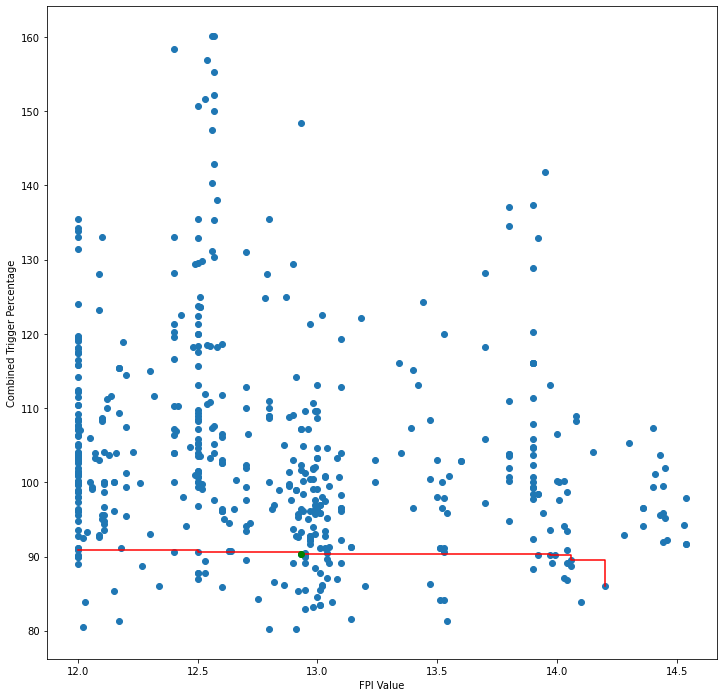

In [124]:
visualize_floor(test_event[["FPI Value", "Combined Trigger Percentage"]])

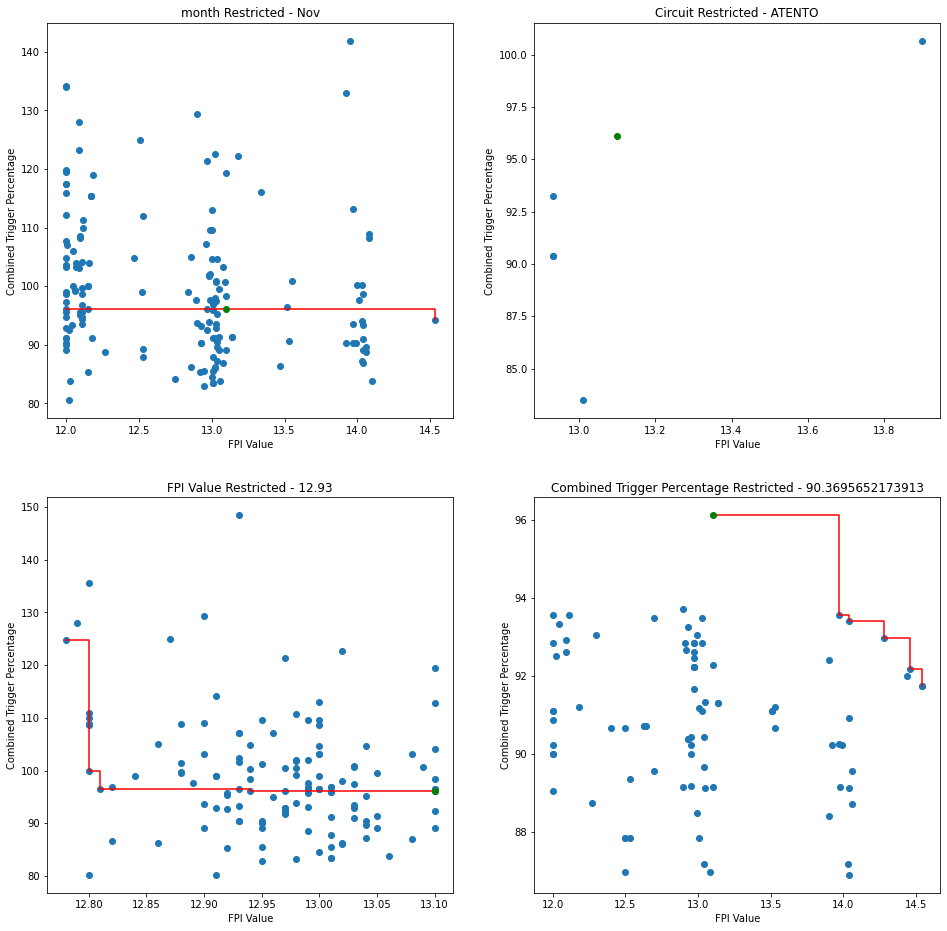

In [125]:
fig, ax = plt.subplots(2,2, figsize = (16,16), squeeze=True)
for i, x in zip(inputs,ax.flatten()):
    if i in categorical_columns:
        data_i = source[source[i]==test_event[i]]
    else:
        data_i = source[(source[i] - test_event[i]).abs() < source[i].std()/4]


    points, _ = visualize_floor(rand_start, fig=fig, ax=x, data=data_i[["FPI Value", "Combined Trigger Percentage"]])
    x.set_xlabel("FPI Value")
    x.set_ylabel("Combined Trigger Percentage")
    x.set_title("{} Restricted - {}".format(i, test_event[i]))

In [126]:
source.Circuit.value_counts()

ENERGY         18
ANTON          14
SAND CANYON    14
DAVENPORT      11
BIG ROCK       10
               ..
ALOLA #2        1
TUBA            1
MORELLO         1
SAGINAW         1
ICEHOUSE        1
Name: Circuit, Length: 192, dtype: int64

In [127]:
source["Weather Station"].value_counts()

SCE Solemint Mtwy           20
SCE Happy Camp Rd           11
SCE Cochran St              11
SCE Arrowhead Springs Rd    11
SCE South Mountain           9
                            ..
SCE RATTLE SNAKE RD          1
SCE Las Posas Hills 2        1
SCE Hopper Mountain          1
ACTON CANYON                 1
SCE Ramona‐Hwy79             1
Name: Weather Station, Length: 242, dtype: int64

## 5. Simulation

[(back to top)](#0.-Findings)

In [128]:
bins = 30

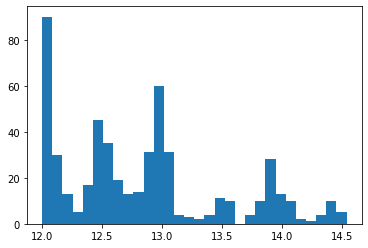

In [129]:
fpi_bin_counts, fpi_bin_endpoints, fpi_hist = plt.hist(source["FPI Value"], bins=bins)
fpi_bin_size = (fpi_bin_endpoints.max() - fpi_bin_endpoints.min())/bins
fpi_dist = fpi_bin_counts/fpi_bin_counts.sum()


In [130]:
def rand_fpi():  return fpi_bin_endpoints[np.random.choice(bins, p = fpi_dist)] + np.random.uniform(fpi_bin_size)

mu_fpi, sig_fpi = source_stats.loc["mean", "FPI Value"], source_stats.loc["std", "FPI Value"]
k, theta = mu_fpi**2/sig_fpi, sig_fpi/mu_fpi

def sigma_fpi(): return np.random.gamma(k, theta)
rand_fpi(), sigma_fpi()

(13.0605984451308, 12.189773539850407)

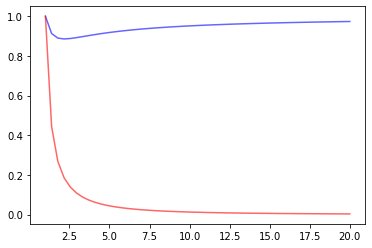

In [131]:
from scipy.special import gamma
x_axis = np.linspace(1, 20)
plt.plot(x_axis, gamma(1+1/x_axis), 'b', alpha=.6, color='blue')
plt.plot(x_axis, gamma(1+2/x_axis) - gamma(1+1/x_axis) ** 2, 'b', alpha=.6, color='red')

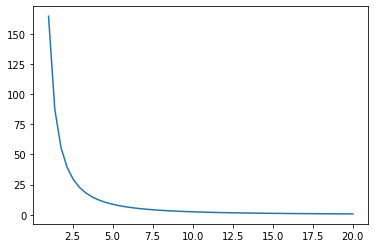

In [132]:
plt.plot(x_axis, mu_fpi**2 * (gamma(1+2/x_axis)/gamma(1+1/x_axis) ** 2 - 1))

In [133]:
mu_fpi, sig_fpi

(12.828053435114498, 0.6828066229383842)

In [134]:
def func1(x): return sig_fpi**2 - mu_fpi**2 * (gamma(1+2/x)/gamma(1+1/x) ** 2 - 1)

from scipy.optimize import fsolve

K = fsolve(func1, 20)[0]
Lambda = mu_fpi / gamma(1+1/K)

K, Lambda, np.isclose([mu_fpi, sig_fpi**2], [Lambda * gamma(1+1/K), Lambda ** 2 * (gamma(1+2/K) - gamma(1+1/K) ** 2)])

(23.396247972852255, 13.129132444537465, array([ True,  True]))

In [135]:
# Trying MLE, given K
mle_LambdaK = sum(source["FPI Value"] ** K)/len(source["FPI Value"])
mle_Lambda = fsolve(lambda x: x**k - mle_LambdaK, 13)[0]
[mle_Lambda * gamma(1+1/K), mle_Lambda ** 2 * (gamma(1+2/K) - gamma(1+1/K) ** 2)]

/Users/tomityrrell/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


[4.029898097402281, 0.04601104087575523]

In [136]:
def weib(x, k, l): return (k/ l) * (x / l)**(k - 1) * np.exp(-(x / l)**k)
def erlang(x, k, l): return l**k * x ** (k-1) * np.exp(-l*x) / gamma(k)

In [137]:
# Trying Erlang
Lambda_e = mu_fpi / sig_fpi**2
K_e = mu_fpi * Lambda_e
np.isclose([mu_fpi, sig_fpi**2], [K_e/Lambda_e, K_e/Lambda_e**2])

array([ True,  True])

Text(0.5, 0, 'FPI Value')

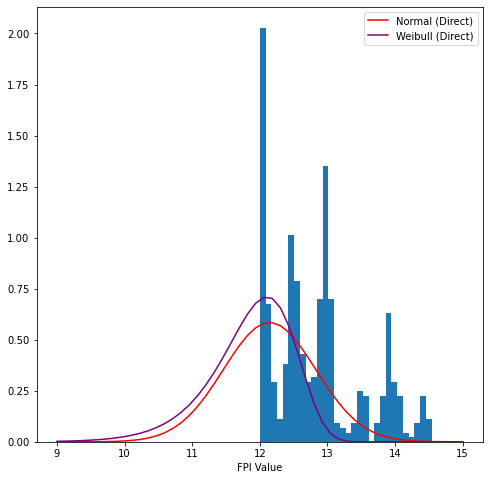

In [138]:
fig, (ax0) = plt.subplots(1,1, figsize = (8,8))
fpi_counts, fpi_bins, fpi_plot = ax0.hist(source["FPI Value"], bins=bins, density=True)
x_axis = np.linspace(9,15)
ax0.plot(x_axis, norm.pdf(x_axis,mu_fpi-sig_fpi,sig_fpi), color='red', label='Normal (Direct)')
ax0.plot(x_axis, weib(x_axis, K, Lambda-1), color='purple', label='Weibull (Direct)')
#ax0.plot(x_axis, weib(x_axis, K, mle_Lambda), color='orange', label='Weibull (Semi-MLE)')
#ax0.plot(x_axis, erlang(x_axis, K_e, Lambda_e), color='orange', label='Erlang')
ax0.legend()
ax0.set_xlabel("FPI Value")

# ax1.hist(list(filter(lambda x: x > 12, [sigma_fpi() for _ in range(500)])), bins=bins, density=True)
# ax1.plot(x_axis, norm.pdf(x_axis,mu_fpi,sig_fpi), color='red')
# ax1.set_xlabel("Gamma FPI Value")

<BarContainer object of 30 artists>

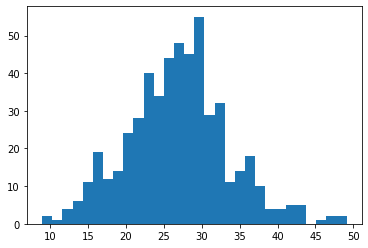

In [139]:
wind_bin_counts, wind_bin_endpoints, wind_hist = plt.hist(source["Wind Sustained"], bins=bins)
wind_dist = wind_bin_counts/wind_bin_counts.sum()
wind_hist

In [140]:
mu_wind = source_stats.loc["mean", "Wind Sustained"]
sigma_wind = source_stats.loc["std", "Wind Sustained"]

print("Mean:  {}".format(mu_wind))
print("Std Dev:  {}".format(sigma_wind))

Mean:  26.911698473282467
Std Dev:  6.645238607728819


In [141]:
def rand_wind():  return wind_bin_endpoints[np.random.choice(30, p = wind_dist)]
def gaussian_wind(): return np.random.normal(mu_wind, sigma_wind)

rand_wind(), gaussian_wind()

(20.988, 25.786133471403296)

Text(0.5, 0, 'Gaussian Wind Value')

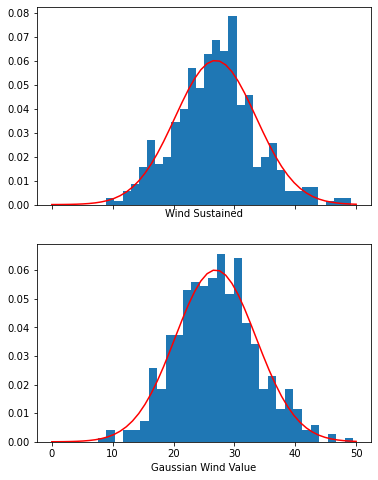

In [142]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize = (6,8), sharex=True)
ax0.hist(source["Wind Sustained"], bins=bins, density=True)
x_axis = np.linspace(0,50)
ax0.plot(x_axis, norm.pdf(x_axis,mu_wind,sigma_wind), color='red')
ax0.set_xlabel("Wind Sustained")

ax1.hist([gaussian_wind() for _ in range(500)], bins=bins, density=True)
x_axis = np.linspace(0,50)
ax1.plot(x_axis, norm.pdf(x_axis,mu_wind,sigma_wind), color='red')
ax1.set_xlabel("Gaussian Wind Value")

In [143]:
n = 1000
simulated_source = np.array([[sigma_fpi(), gaussian_wind()] for _ in range(n)])
simulated_source

array([[12.24485794, 16.45323278],
       [12.50395997, 20.95015307],
       [14.26402341, 34.98174588],
       ...,
       [12.76214916, 20.91983702],
       [13.59869107, 26.69627009],
       [12.52004122, 24.61897579]])

Text(0, 0.5, 'Combined Trigger Percentage')

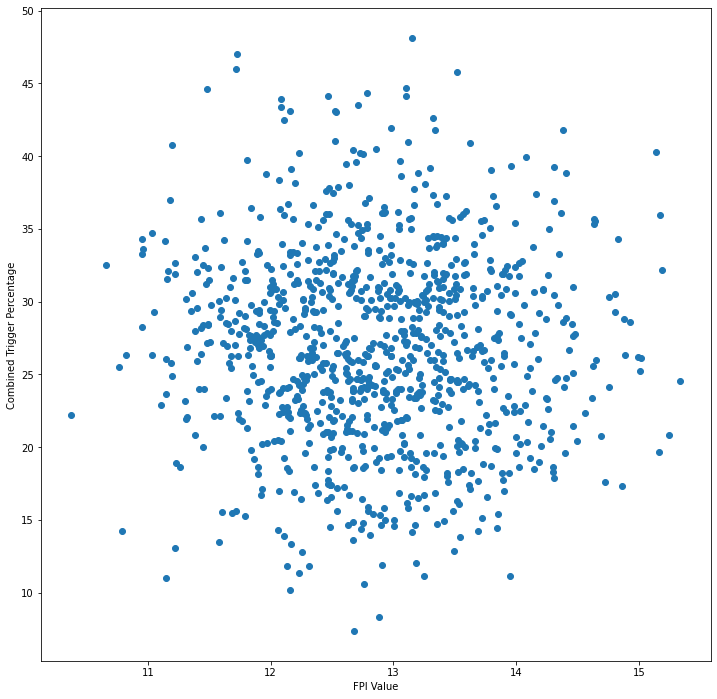

In [144]:
fig, ax = plt.subplots(1,1, figsize = (12,12))
# for (p,q),x in zip(itertools.combinations(features,2),ax):
data = simulated_source
ax.scatter(data[:,0], data[:,1])
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])

In [145]:
outlier_prob = .0466/2*.3283/2
events = 500000
circuits = 500
outlier_prob, outlier_prob*circuits

(0.003824695, 1.9123474999999999)

### 5a. Simulation of Gust Speeds from correlation with Wind

0.5836630645563535 30.276223380666373 [[ 0.00128476 -0.03457501]
 [-0.03457501  0.98709781]]


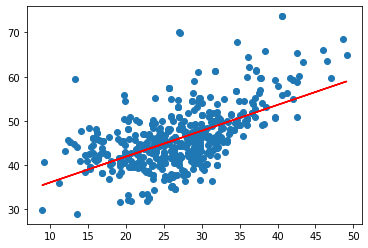

In [146]:
# fit line to wind/gust
def line(x,a,b):
    return a*x + b
x_data = source["Wind Sustained"].values
y_data = source["Gust Sustained"].values
(wind_slope,wind_bias), C = curve_fit(line,x_data,y_data)
print(wind_slope, wind_bias, C)

wind_values = source[["Wind Sustained","Gust Sustained"]].values
plt.scatter(wind_values[:,0], wind_values[:,1])
plt.plot(x_data, line(x_data,wind_slope,wind_bias), color='red')

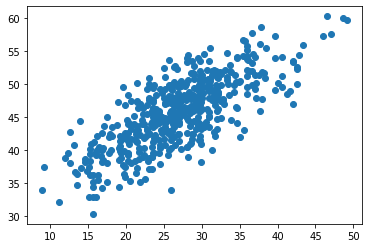

In [147]:
# Gust data can be fit from wind data + noise
def predict_gust(wind, noise = True):
    noise = [np.random.normal(0,stats_summary("Gust Sustained")[1]/2) for _ in range(len(wind))]
    return wind_slope*wind + wind_bias + noise

plt.scatter(wind_values[:,0], predict_gust(wind_values[:,0]))

In [148]:
stats_summary("Wind Sustained")

(26.911698473282467, 6.645238607728819)

### 5b. Simulation via Gaussian Random Walk

In [149]:
def gaussian_walk(sigma, n=250):
    curr=0
    steps = []
    walk = []
    for i in range(n):
        step = np.random.normal(0,sigma)
        curr = max(0, curr+step)
        steps.append(step)
        walk.append(curr)
    return np.array(steps), np.array(walk)

In [ ]:
n=250
mu, sigma = stats_summary("Wind Sustained")
sigma_walk = (mu - sigma)/2/np.sqrt(n)
plt.plot(np.arange(250),gaussian_walk(sigma_walk)[1])
plt.plot(np.arange(250),2*np.sqrt(np.arange(250))*sigma_walk, color='red')
#plt.plot(np.arange(251),-2*np.sqrt(np.arange(251))*sigma_walk, color='red')

In [ ]:
def gaussian_simulation(field_name, stds = 2, n=250):
    mu, sigma = stats_summary(field_name)
    sigma_walk = (mu - 2*sigma)/stds/np.sqrt(n)
    return gaussian_walk(sigma_walk, n)

In [ ]:
timestamps = lambda n: [pd.Timestamp(2021,10,23,12) + i*pd.Timedelta('10m') for i in range(n)]

def gaussian_circuit(circuit_name, n=250):
    _, fpi_values = gaussian_simulation("FPI Value", stds=2, n=n)
    _, wind_values = gaussian_simulation("Wind Sustained", stds=1, n=n)
    
    # predict gust values from wind simulation
    gust_values = predict_gust(wind_values)
    
    # compute percentage thresholds 
    if circuit_name in source.Circuit.values:
        perc_values = np.max([wind_values/source[source.Circuit==circuit_name]["Wind Threshold"].mean() * 100, 
                          gust_values/source[source.Circuit==circuit_name]["Gust Threshold"].mean()] * 100, axis=0)
    else:
        perc_values = np.max([wind_values/31*100, 
                          gust_values/46*100], axis=0)

    simulation = {"Circuit": [circuit_name] * n,
                  "Timestamp": timestamps(n),
                  "FPI Value": fpi_values,
                  "Wind Sustained": wind_values,
                  "Gust Sustained": gust_values,
                  "Combined Trigger Percentage": perc_values}
    return pd.DataFrame(simulation)

In [ ]:
gaussian_circuit("ANTON")

In [ ]:
simulation = gaussian_circuit("ENERGY")

#circuit_simulation = pd.DataFrame(np.hstack([fpi.reshape(-1,1), perc.reshape(-1,1)]), columns = ["FPI Value", "Combined Trigger Percentage"])
plt.scatter(simulation["FPI Value"], simulation["Combined Trigger Percentage"])
plt.scatter(source["FPI Value"].values, source["Combined Trigger Percentage"].values, color='red')

In [ ]:
plt.scatter(simulation["Wind Sustained"], simulation["Gust Sustained"])
plt.scatter(source["Wind Sustained"].values, source["Gust Sustained"].values, color='red')
plt.plot(np.arange(0,40), line(np.arange(0,40),wind_slope,wind_bias), color='red')

In [153]:
simulation = pd.read_csv("../data/sims/simulation.csv")
simulation = simulation[simulation.circuit == "ENERGY"]

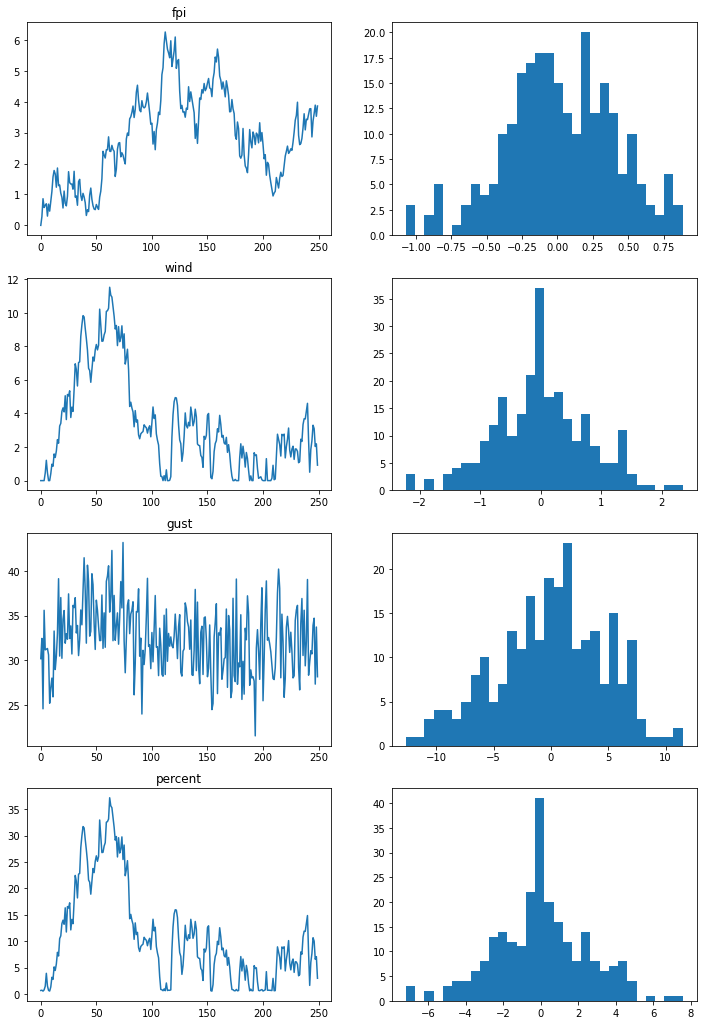

In [156]:
fig, ax = plt.subplots(4,2, figsize=(12,18))
for i,k in zip(range(4),simulation.columns[2:]):
    ax[i][0].set_title(k)
    ax[i][0].plot(np.arange(250),simulation[k])
    ax[i][1].hist(np.diff(simulation[k]), bins=30)

In [ ]:
count = 0
for _ in range(200):
    simulation = gaussian_circuit("Energy")
    
    if ((simulation["FPI Value"] > 12) & (simulation["Combined Trigger Percentage"] > 1)).any():
        count+=1
print(count)

### 5c. Create and Export Simulation

In [ ]:
simulations = []
for s in source.Circuit.unique():
    simulations.append(gaussian_circuit(s))

In [ ]:
full_sim = pd.concat(simulations).sort_values(by="Timestamp")
full_sim.columns = ["circuit", "time", "fpi", "wind", "gust", "percent"]
full_sim.to_csv("./data/simulation.csv", index=False)

#### Macrobase SQL
IMPORT FROM CSV FILE './simulation.csv' INTO simulation(circuit string, time timestamp, fpi double, wind double, gust double, percent double);

#### PostGreSQL
CREATE TABLE simulation(circuit varchar, time timestamp, fpi double precision, wind double precision, gust double precision, percent double precision);
\copy simulation FROM './simulation.csv' CSV HEADER;

In [ ]:
full_sim = pd.read_csv("./data/simulation.csv")
full_sim.head()

In [ ]:
full_sim_outliers = full_sim[(full_sim["fpi"] > 12) & (full_sim["percent"] > 70)]
plt.scatter(full_sim_outliers.fpi, full_sim_outliers.percent)
plt.scatter(source["FPI Value"].values, source["Combined Trigger Percentage"].values, color='red')

### 5d. Post-macrobase analysis

In [ ]:
anaconda_mb = pd.read_csv('./data/anaconda_mb.csv')
plt.scatter(anaconda_mb.fpi, anaconda_mb.percent)
plt.scatter(source["FPI Value"].values, source["Combined Trigger Percentage"].values, color='red')

In [ ]:
frozen_mb = pd.read_csv('./data/frozen_mb.csv')
plt.scatter(frozen_mb.fpi, frozen_mb.percent)
plt.scatter(source["FPI Value"].values, source["Combined Trigger Percentage"].values, color='red')

In [ ]:
sce_rollup = pd.read_csv('./data/sce_rollup_2019.csv')
sce_rollup.rename({"Circuit":"circuit"}, axis=1, inplace=True)
sim_rollup = full_sim.merge(sce_rollup[~(sce_rollup["circuit"].duplicated(keep="last"))], on="circuit", how="inner")

In [ ]:
sim_rollup.columns = sim_rollup.columns.str.lower()
sim_rollup.columns = sim_rollup.columns.str.replace(" ", "_")
sim_rollup.columns = sim_rollup.columns.str.replace("/", "_")

In [ ]:
sim_rollup.drop(sim_rollup.columns[6:13], axis=1, inplace=True)

In [ ]:
sim_rollup.head()

In [ ]:
sim_rollup.tail()

In [ ]:
sim_rollup.to_csv("./data/simulation_rollup.csv", index=False)

In [ ]:
for s in sim_rollup.columns:
    print(s + ",")